# 1. Portfolio Construction

To create a robust portfolio with Sharpe of 2, max drawdowns of 2.5% and VaR at 7% we:
* Select diversified set of underlyings- across asset classes, sectors and geographies to mitigate factor risks.
* Include hedging instruments like gold, volatility assets, inverse ETFs to minimize drawdowns.
* Optimize portfolio to maintain low sensitivity to market shocks (low portfolio beta).

In [1]:
tickers = [
    'SPY',  # SPX ETF- market wide equity returns
    'QQQ',  # Nasdaq ETF- sector specific diversification
    'EEM',  # Emerging Market Stocks- international diversification
    'GLD',  # Gold- protect during high volatility
    'UNG',  # Natural Gas- commodity diversification
    'TIP',  # Inflation-Protected Securities- hedge against high inflation
    'AMT',  # Communications- sector specific diversification
    'TLT',  # U.S. Treasury Bonds- safe during stress
    '^VIX', # VIX (can use ETNs like VIXY but data before 2010 not available)- hedge against market downturns
    'SH',   # ProShares Short S&P500- offset systematic risk associated with equity returns (not perfect inverse of SPY)
]

In [2]:
# Download data
import yfinance as yf
data = yf.download(tickers, period="max")['Adj Close']

# Calculate daily returns
returns = data.pct_change(fill_method=None).dropna()
returns.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,AMT,EEM,GLD,QQQ,SH,SPY,TIP,TLT,UNG,^VIX
Date,,,,,,,,,,
2007-04-19,-0.008285,-0.008069,-0.012431,0.003110,0.000823,-0.000272,-0.000497,-0.001694,-0.004136,0.009662
2007-04-20,-0.007342,0.011914,0.017326,0.005537,-0.008558,0.009441,0.000398,-0.002602,-0.020174,-0.037480
2007-04-23,-0.010456,-0.003979,-0.006405,0.001542,0.003818,-0.003768,0.002285,0.003630,0.029471,0.080365
2007-04-24,0.007731,-0.000163,-0.007764,0.005058,0.000331,0.000405,0.001685,0.003730,0.001765,0.006135
2007-04-25,-0.000767,0.012393,0.002362,0.013349,-0.010084,0.009182,0.000099,-0.003491,0.009199,0.006860


# 2. Sizing Framework

While Modern Portfolio Theory (MPT) provides a foundation for mean-variance optimization, it does not enforce conditions on drawdowns in stressed market scenarios. Therefore, we develop a customized optimization function that maximizes the Sharpe ratio while incorporating constraints on drawdowns and VaR.

This optimization is built using approximately 18 years of historical data, ensuring robustness and reliability in various market conditions.

In [3]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def portfolio_metrics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def max_drawdown(returns):
    returns = pd.DataFrame(returns)
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min().values[0]

def var_95(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    daily_var = -np.percentile(portfolio_returns, 5)
    annual_var = daily_var * np.sqrt(252)
    return annual_var

# Define constraints and bounds
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: portfolio_metrics(weights, returns)[2] - 2},
    {'type': 'ineq', 'fun': lambda weights: 0.07 - var_95(weights, returns)},
    {'type': 'ineq', 'fun': lambda weights: 0.025 + max_drawdown(np.dot(returns, weights))}
)

bounds = tuple((-1, 1) for _ in range(len(tickers)))

init_weights = len(tickers) * [1. / len(tickers)]

def negative_sharpe_ratio(weights):
    return -portfolio_metrics(weights, returns)[2]

optimized = minimize(
    negative_sharpe_ratio, 
    init_weights, 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints, 
    options={'ftol': 1e-10, 'maxiter': 1000}
)

opt_weights = optimized.x
portfolio_return, portfolio_std, sharpe_ratio = portfolio_metrics(opt_weights, returns)
annual_var = var_95(opt_weights, returns)
portfolio_drawdown = max_drawdown(np.dot(returns, opt_weights))

print(f"Start Date: \t {returns.index.min().date()}")
print(f"End Date: \t {returns.index.max().date()}")
print(f"Annual Return: \t {portfolio_return:.2%}")
print(f"Annual Vol: \t {portfolio_std:.2%}")
print(f"Sharpe Ratio: \t {sharpe_ratio:.2f}")
print(f"Max Drawdown: \t {portfolio_drawdown:.2%}")
print(f"VaR: \t \t {annual_var:.2%}")

Start Date: 	 2007-04-19
End Date: 	 2024-05-31
Annual Return: 	 3.89%
Annual Vol: 	 1.94%
Sharpe Ratio: 	 2.01
Max Drawdown: 	 -2.50%
VaR: 	 	 2.46%


### Statistical Plots

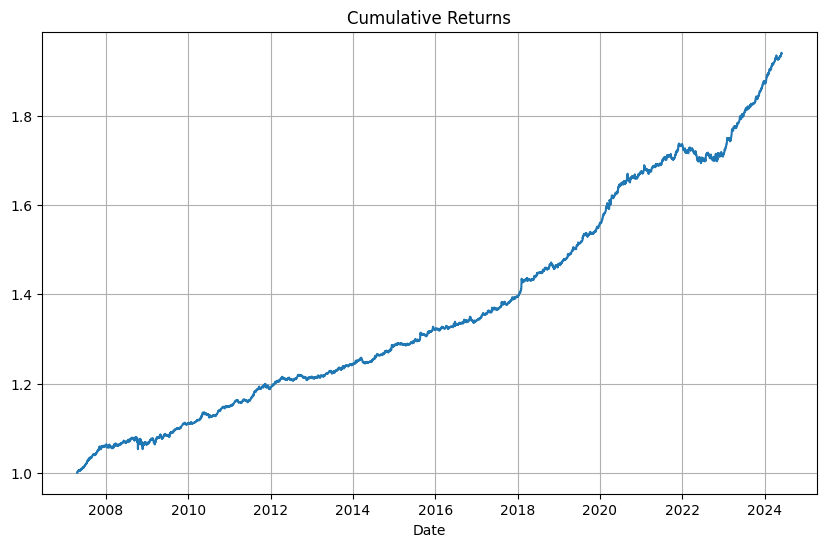

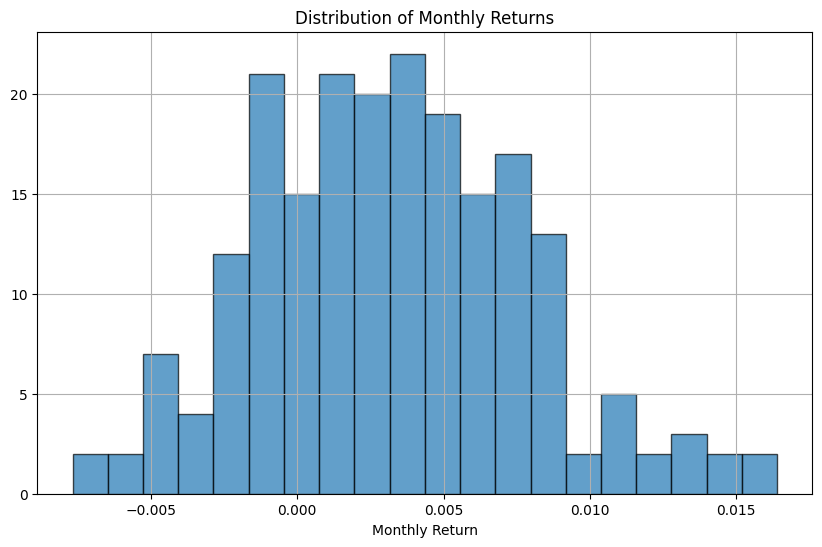

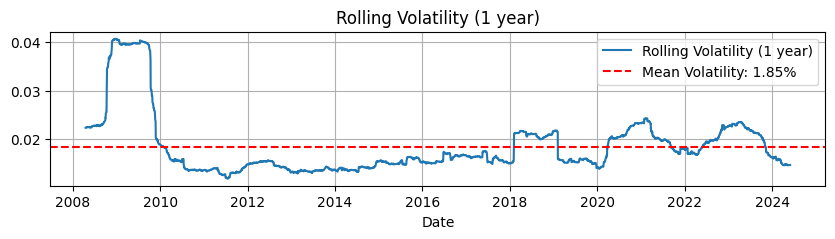

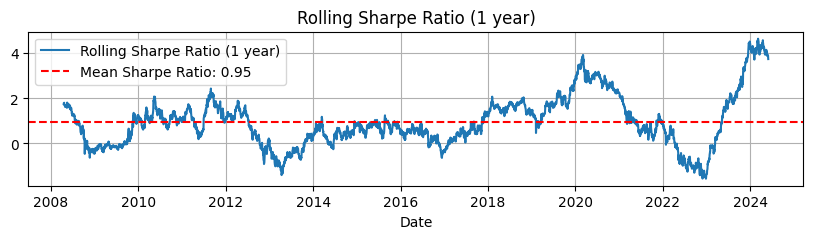

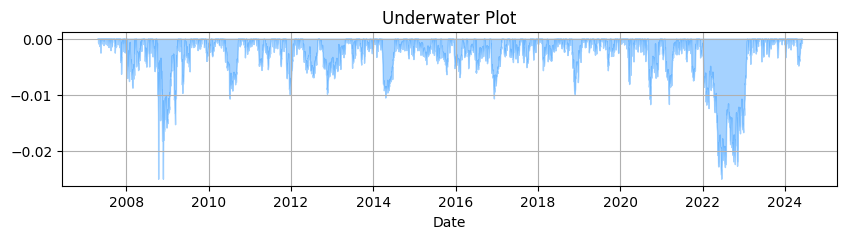

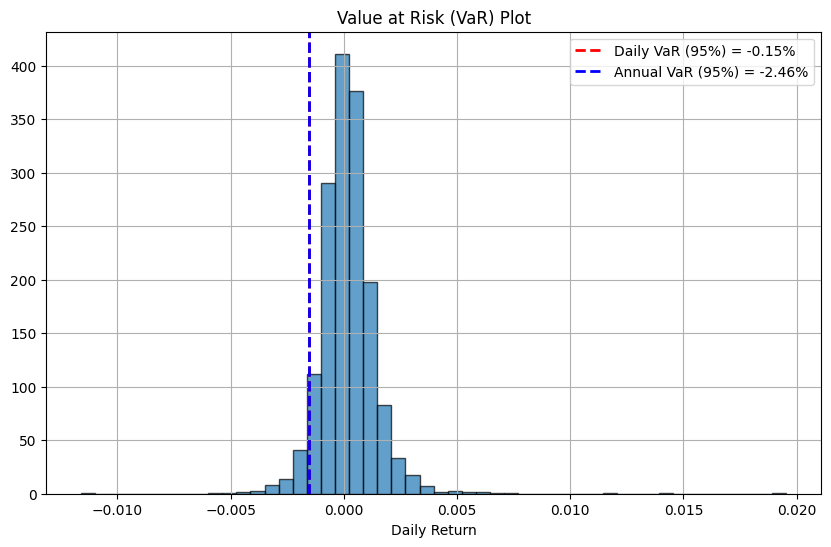

In [4]:
import matplotlib.pyplot as plt

# Calculate the portfolio returns using optimized weights
optimized_portfolio_returns = np.dot(returns, opt_weights)
optimized_portfolio_returns = pd.Series(optimized_portfolio_returns, index=returns.index)

# Cumulative Returns Plot
def plot_cumulative_returns(returns):
    cumulative_returns = (1 + returns).cumprod()
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Cumulative Returns')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

# Distribution of Monthly Returns
def plot_monthly_returns_distribution(returns):
    monthly_returns = returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
    plt.figure(figsize=(10, 6))
    plt.hist(monthly_returns, bins=20, edgecolor='k', alpha=0.7)
    plt.title('Distribution of Monthly Returns')
    plt.xlabel('Monthly Return')
    plt.grid(True)
    plt.show()
    
# Rolling Volatility (1 year)
def plot_rolling_volatility(returns, window=252):  # 252 trading days ~ 1 year
    rolling_volatility = returns.rolling(window).std() * np.sqrt(252)
    mean_volatility = rolling_volatility.mean()
    plt.figure(figsize=(10, 2))
    plt.plot(rolling_volatility, label='Rolling Volatility (1 year)')
    plt.axhline(mean_volatility, color='red', linestyle='--', label=f'Mean Volatility: {mean_volatility:.2%}')
    plt.title('Rolling Volatility (1 year)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.show()

# Rolling Sharpe Ratio (1 year)
def plot_rolling_sharpe(returns, window=252):  # 252 trading days ~ 1 year
    rolling_sharpe = (returns.rolling(window).mean() * 252 - 0.02) / (returns.rolling(window).std() * np.sqrt(252))
    mean_sharpe = rolling_sharpe.mean()
    plt.figure(figsize=(10, 2))
    plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio (1 year)')
    plt.axhline(mean_sharpe, color='red', linestyle='--', label=f'Mean Sharpe Ratio: {mean_sharpe:.2f}')
    plt.title('Rolling Sharpe Ratio (1 year)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.show()

# Underwater Plot
def plot_underwater(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    plt.figure(figsize=(10, 2))
    plt.fill_between(drawdown.index, drawdown, color='dodgerblue', alpha=0.4)
    plt.title('Underwater Plot')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

# Annual Value at Risk (VaR) Plot
def plot_var(returns, confidence_level=0.95):
    daily_var = np.percentile(returns, (1 - confidence_level) * 100)
    annual_var = daily_var * np.sqrt(252)
    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=50, edgecolor='k', alpha=0.7, density=True)
    plt.axvline(daily_var, color='red', linestyle='dashed', linewidth=2, label=f'Daily VaR ({confidence_level * 100:.0f}%) = {daily_var:.2%}')
    plt.axvline(annual_var / np.sqrt(252), color='blue', linestyle='dashed', linewidth=2, label=f'Annual VaR ({confidence_level * 100:.0f}%) = {annual_var:.2%}')
    plt.title('Value at Risk (VaR) Plot')
    plt.xlabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate the plots
plot_cumulative_returns(optimized_portfolio_returns)
plot_monthly_returns_distribution(optimized_portfolio_returns)
plot_rolling_volatility(optimized_portfolio_returns)
plot_rolling_sharpe(optimized_portfolio_returns)
plot_underwater(optimized_portfolio_returns)
plot_var(optimized_portfolio_returns)

# 3. Stress Testing
### Historical Crashes
The statistical plots above give an idea about ~18 year risk, return metrics of the portfolio. \
Now we stress test our portfolio specifically during major historical events and present the risk return metrics.

2008 Financial Crisis:
  Sharpe Ratio: 0.65
  Max Drawdown: -2.50%
  VaR (95%): -4.79%


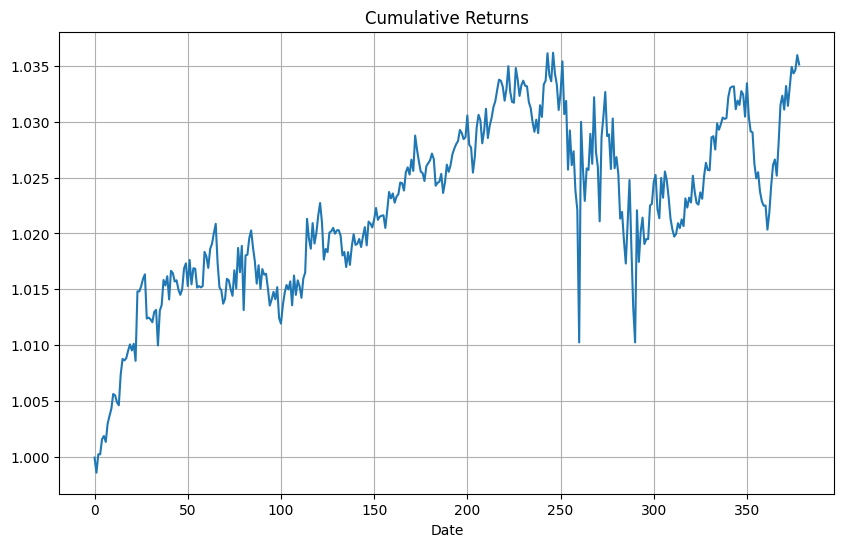

European Sovereign Debt Crisis:
  Sharpe Ratio: 2.17
  Max Drawdown: -1.07%
  VaR (95%): -2.04%


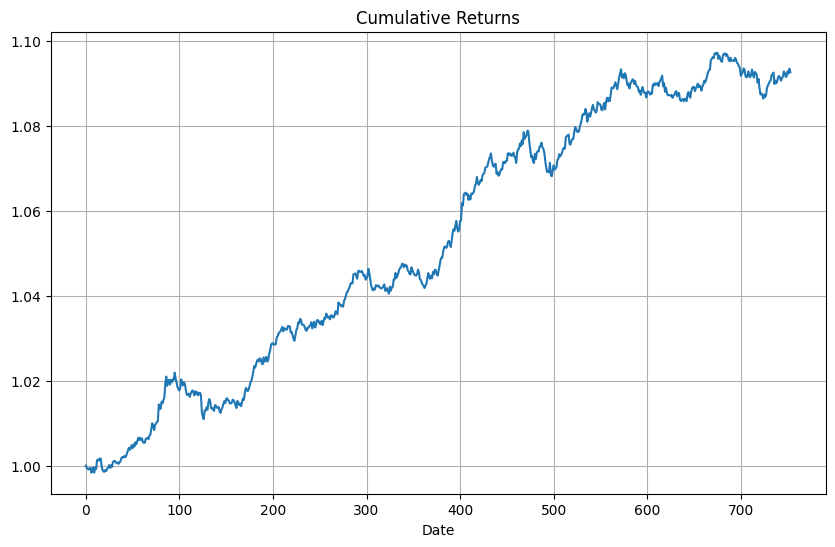

COVID-19 Pandemic:
  Sharpe Ratio: 2.31
  Max Drawdown: -1.17%
  VaR (95%): -3.21%


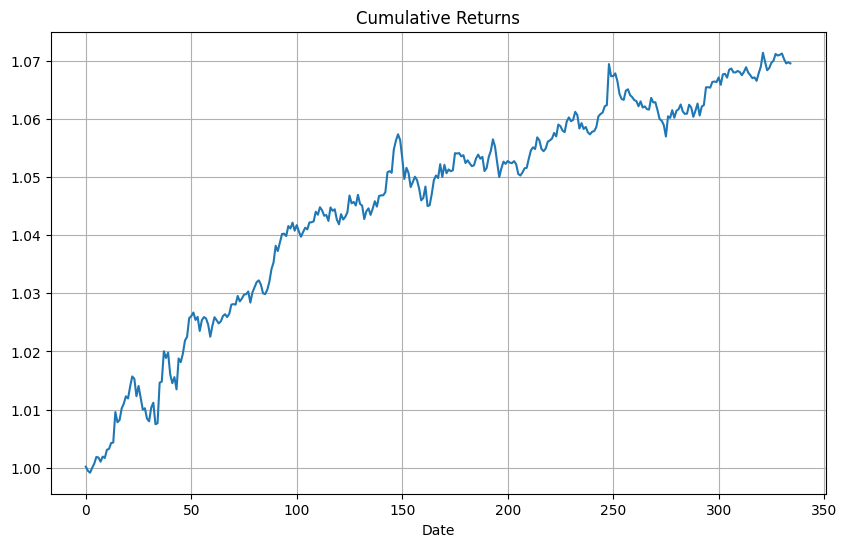

Inflation and War:
  Sharpe Ratio: 1.55
  Max Drawdown: -2.50%
  VaR (95%): -2.66%


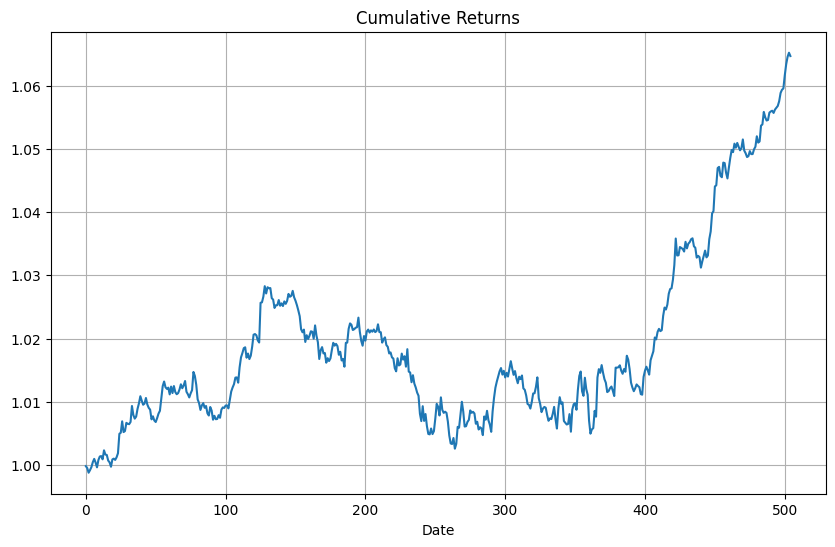

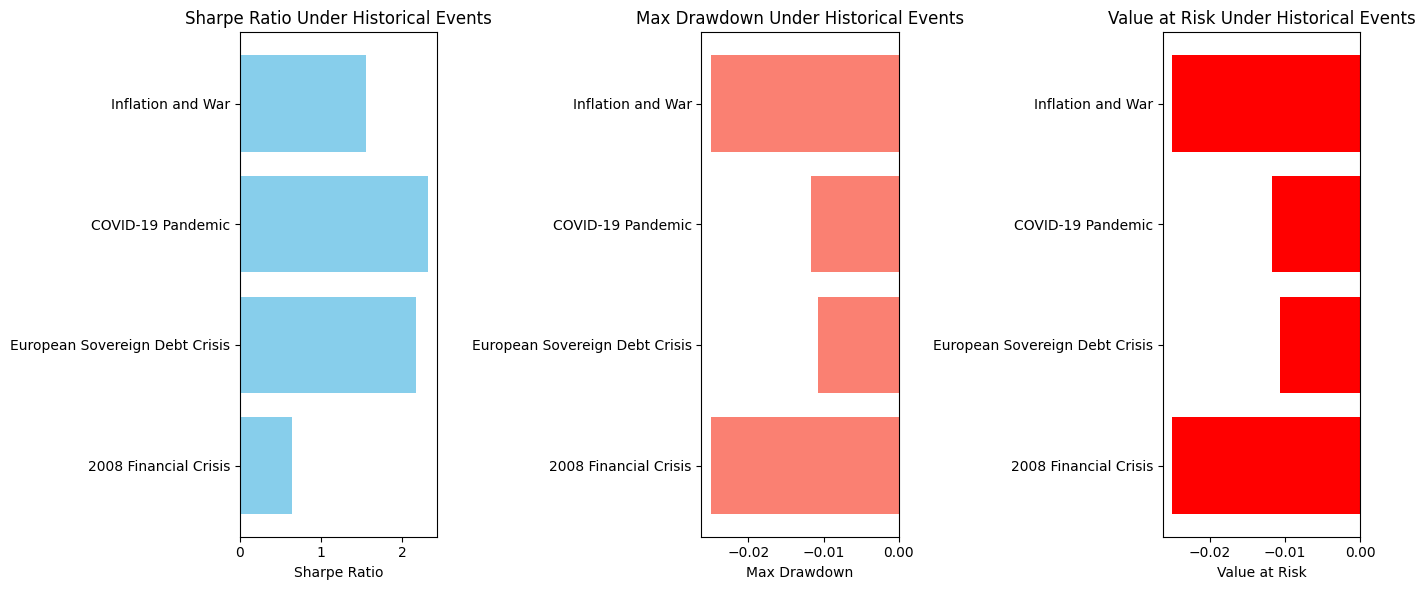

In [5]:
# Define Historical Events
historical_events = {
    '2008 Financial Crisis': ('2007-10-01', '2009-04-01'),
    'European Sovereign Debt Crisis': ('2010-01-01', '2012-12-31'),
    'COVID-19 Pandemic': ('2020-02-01', '2021-06-01'),
    'Inflation and War': ('2021-06-01', '2023-06-01')
}

# Function to calculate portfolio returns
def calculate_portfolio_returns(weights, returns):
    return np.dot(returns, weights)

# Function to apply historical event
def apply_historical_event(weights, returns, start_date, end_date):
    event_returns = returns.loc[start_date:end_date]
    portfolio_event_returns = calculate_portfolio_returns(weights, event_returns)
    return portfolio_event_returns

# Evaluate Historical Events
def evaluate_historical_events(weights, returns, events):
    results = {}
    for event_name, (start_date, end_date) in events.items():
        event_returns = apply_historical_event(weights, returns, start_date, end_date)
        if len(event_returns) == 0:
            continue
        event_cumulative_returns = pd.Series((1 + event_returns).cumprod(), index=returns.loc[start_date:end_date].index)
        event_drawdown = (event_cumulative_returns - event_cumulative_returns.cummax()) / event_cumulative_returns.cummax()
        
        # Calculate metrics
        final_cumulative_return = event_cumulative_returns.iloc[-1] - 1
        max_drawdown = event_drawdown.min()
        annualized_return = (1 + final_cumulative_return) ** (252 / len(event_returns)) - 1
        annualized_volatility = np.std(event_returns) * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility
        daily_var = np.percentile(event_returns, 5)
        annual_var = daily_var * np.sqrt(252)
        
        results[event_name] = {
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'VaR (95%)': annual_var
        }
        
        print(f"{event_name}:")
        print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"  Max Drawdown: {max_drawdown:.2%}")
        print(f"  VaR (95%): {annual_var:.2%}")
        plot_cumulative_returns(event_returns)
        
    return results

# Generate Historical Event Test Results
historical_event_test_results = evaluate_historical_events(opt_weights, returns, historical_events)

# Generate the plots
def plot_historical_event_test_results(historical_event_test_results):
    fig, ax = plt.subplots(1, 3, figsize=(14, 6))

    event_names = list(historical_event_test_results.keys())
    sharpe_ratio = [historical_event_test_results[name]['Sharpe Ratio'] for name in event_names]
    max_drawdowns = [historical_event_test_results[name]['Max Drawdown'] for name in event_names]
    var_95 = [historical_event_test_results[name]['VaR (95%)'] for name in event_names]

    ax[0].barh(event_names, sharpe_ratio, color='skyblue')
    ax[0].set_xlabel('Sharpe Ratio')
    ax[0].set_title('Sharpe Ratio Under Historical Events')

    ax[1].barh(event_names, max_drawdowns, color='salmon')
    ax[1].set_xlabel('Max Drawdown')
    ax[1].set_title('Max Drawdown Under Historical Events')
    
    ax[2].barh(event_names, max_drawdowns, color='red')
    ax[2].set_xlabel('Value at Risk')
    ax[2].set_title('Value at Risk Under Historical Events')

    plt.tight_layout()
    plt.show()

plot_historical_event_test_results(historical_event_test_results)

### Conclusion:
We note that in historical crashes, our portfolio maintains required drawdowns and VaR with the only exception of Sharpe in 2008 Financial crisis.

### Portfolio returns as compared to underlying assets in 2022 Inflation and War Crash

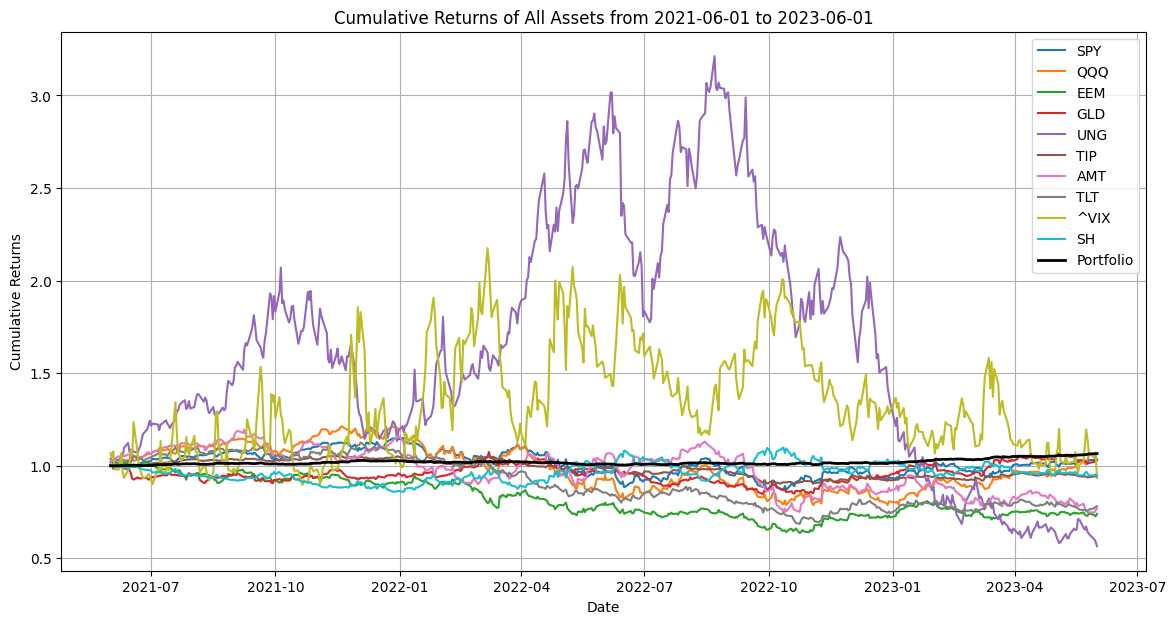

In [6]:
import matplotlib.pyplot as plt

# Define the start and end date'2021-06-01', '2023-06-01'
start_date = '2021-06-01'
end_date = '2023-06-01'

# Filter the returns for the specified date range
filtered_returns = returns.loc[start_date:end_date]

# Calculate cumulative returns
cumulative_returns = (1 + filtered_returns).cumprod()
portfolio_cumulative_returns = (1 + np.dot(filtered_returns, opt_weights)).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
    
# Plot portfolio cumulative returns
plt.plot(cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio', linewidth=2, color='black')

plt.title(f'Cumulative Returns of All Assets from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## Hypothetical Scenarios

Now we create some hypothetical market shocks and scenarios and test our portfolio's performance- 
* Equity Market Crash of 50%
* Real Estate Crash of 50%
* Interest Rate Crash by 2-3%
* Equity Volatility shock of 50%

Methodology-
* Assume shock in 1 asset corresponding to the stressed market scenario.
* Perform linear regression for each asset against the shocked asset and calculate the shocks in other assets.
* Calculate the returns of the overall portfolio using the shocked returns.

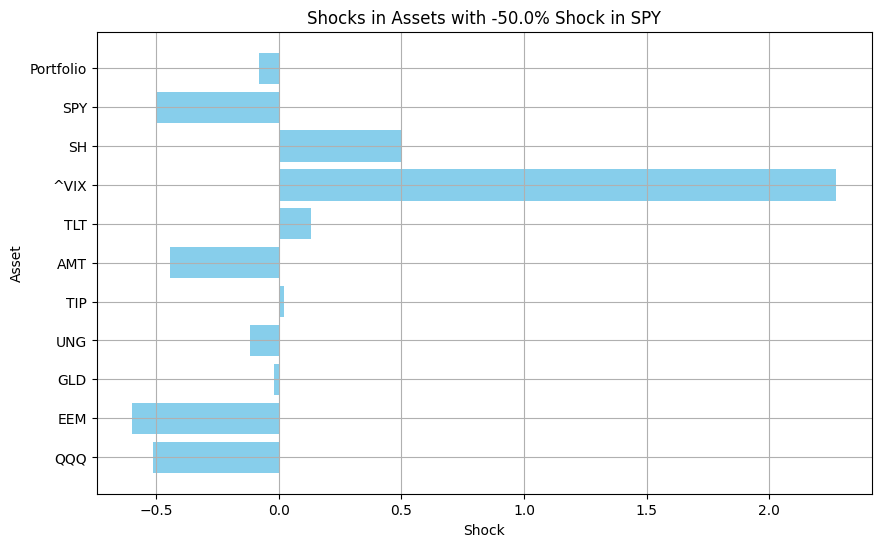

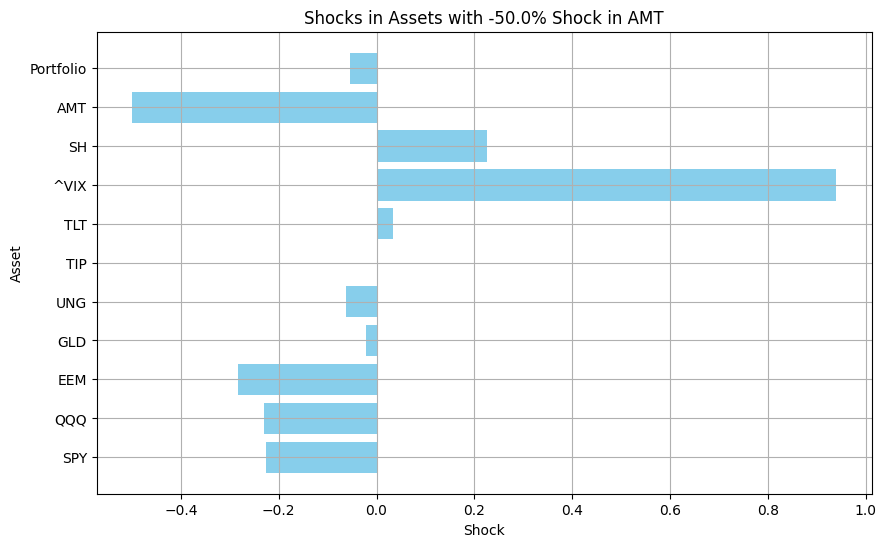

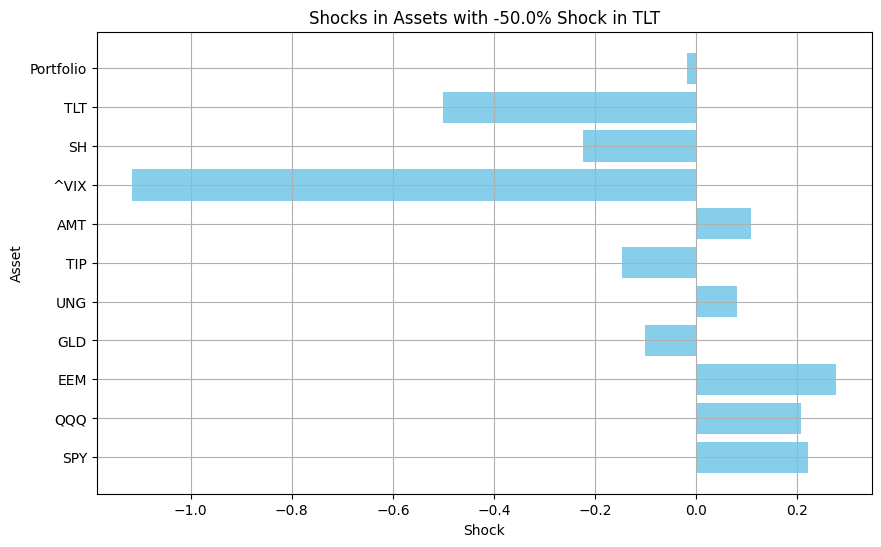

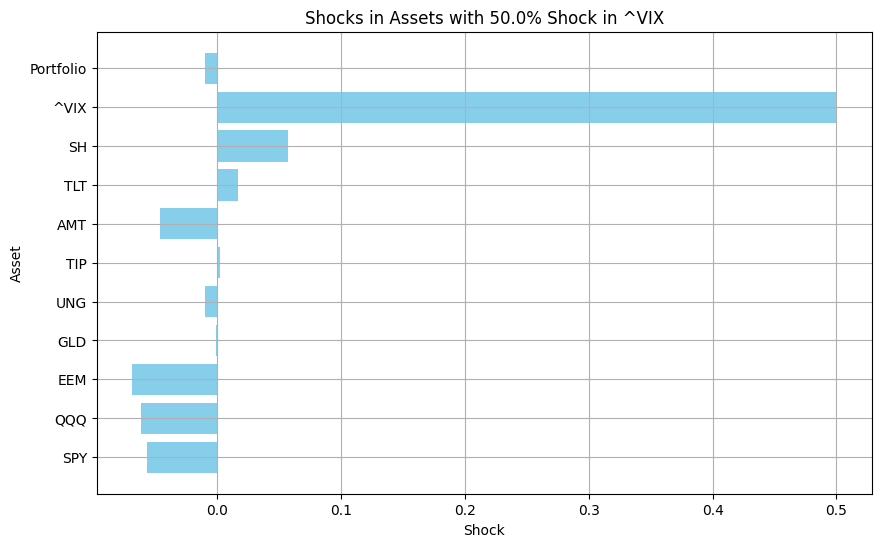

In [7]:
from sklearn.linear_model import LinearRegression

# Function to calculate shocked portfolio return and plot results
def calculate_shocked_portfolio_and_plot(shock_ticker, shock_value):
    # Perform linear regression for each asset against the shock ticker returns
    shock_returns = returns[shock_ticker].values.reshape(-1, 1)
    shocked_betas = {}

    for ticker in tickers:
        if ticker != shock_ticker:
            asset_returns = returns[ticker].values.reshape(-1, 1)
            reg = LinearRegression().fit(shock_returns, asset_returns)
            shocked_betas[ticker] = reg.coef_[0][0]

    # Calculate shocks in other assets based on their beta values
    shocked_returns = {}
    for ticker, beta in shocked_betas.items():
        shocked_returns[ticker] = beta * shock_value

    # Calculate the overall portfolio returns using optimized weights and the shocked returns
    shocked_portfolio_return = 0
    for ticker, shock in shocked_returns.items():
        shocked_portfolio_return += shock * opt_weights[tickers.index(ticker)]

    # Include the shock in the ticker itself
    shocked_portfolio_return += shock_value * opt_weights[tickers.index(shock_ticker)]

    # Prepare data for plotting
    assets = list(shocked_returns.keys()) + [shock_ticker, 'Portfolio']
    shocks = list(shocked_returns.values()) + [shock_value, shocked_portfolio_return]

    # Plot the shocks
    plt.figure(figsize=(10, 6))
    plt.barh(assets, shocks, color='skyblue')
    plt.title(f'Shocks in Assets with {shock_value*100}% Shock in {shock_ticker}')
    plt.xlabel('Shock')
    plt.ylabel('Asset')
    plt.grid(True)
    plt.show()

# Assume a 50% shock in SPY and plot
shock_spy = -0.50
calculate_shocked_portfolio_and_plot('SPY', shock_spy)

# Assume a 50% shock in AMT and plot
shock_amt = -0.50
calculate_shocked_portfolio_and_plot('AMT', shock_amt)

# Assume a 50% shock in TLT and plot
shock_tlt = -0.50
calculate_shocked_portfolio_and_plot('TLT', shock_tlt)

# Assume a 50% shock in VIXY and plot
shock_vix = 0.50
calculate_shocked_portfolio_and_plot('^VIX', shock_vix)

Overall portfolio shocks are limited. \
As a sanity check we do a linear regression of the portfolio against every asset to check dependencies.

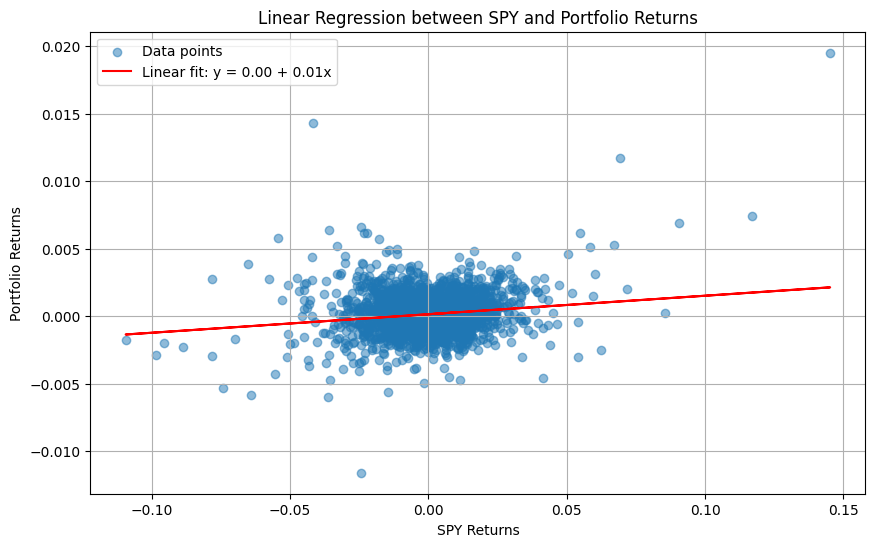

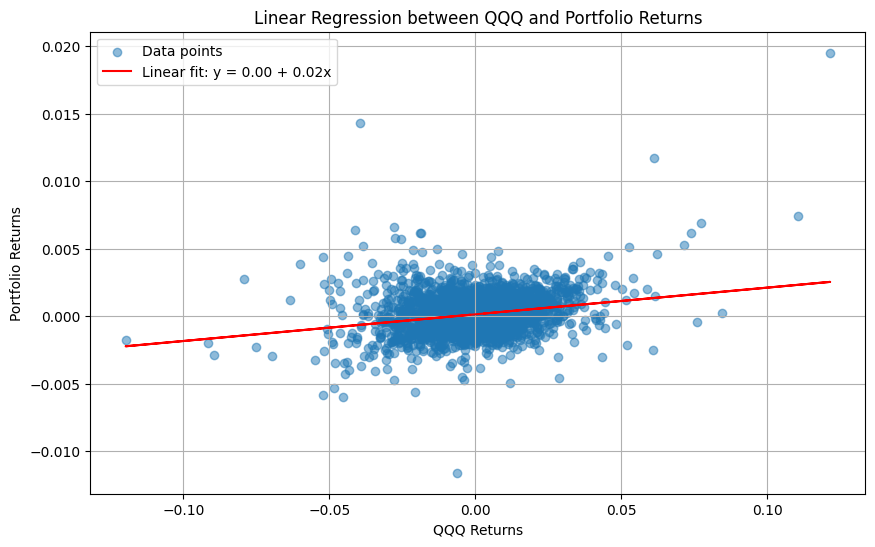

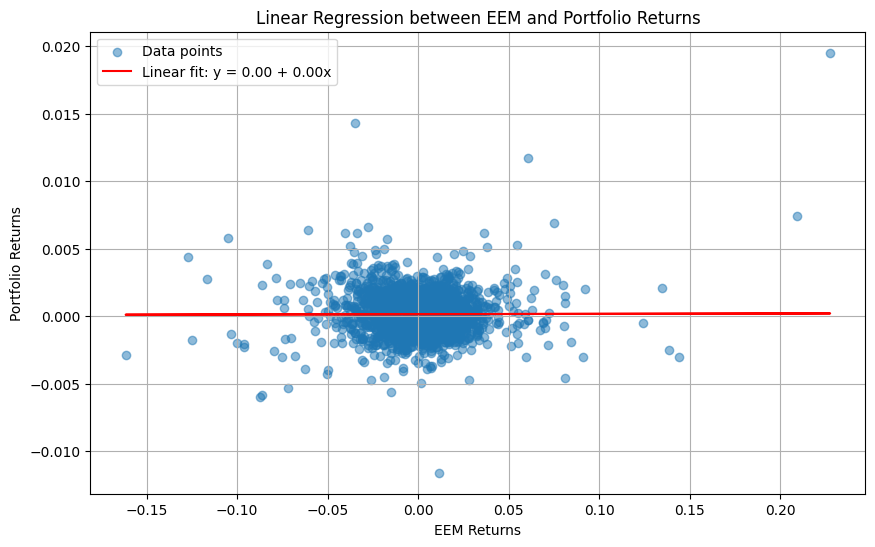

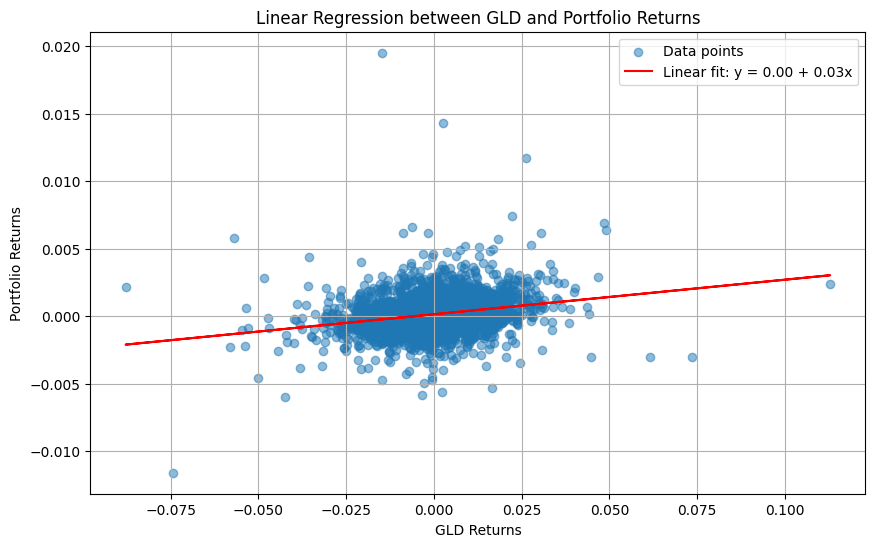

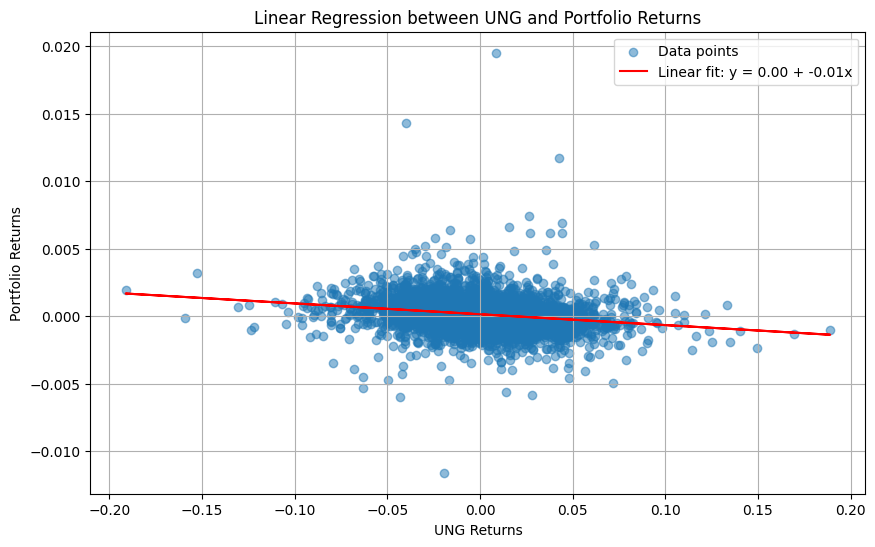

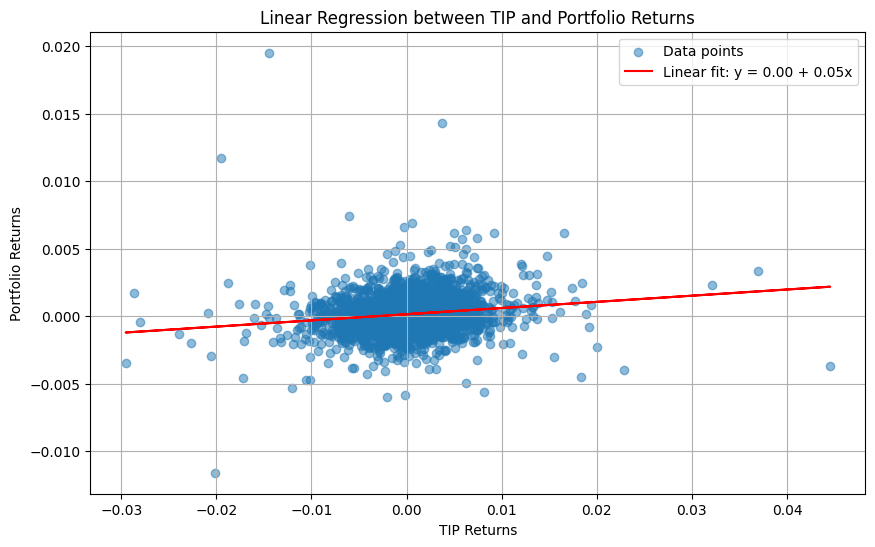

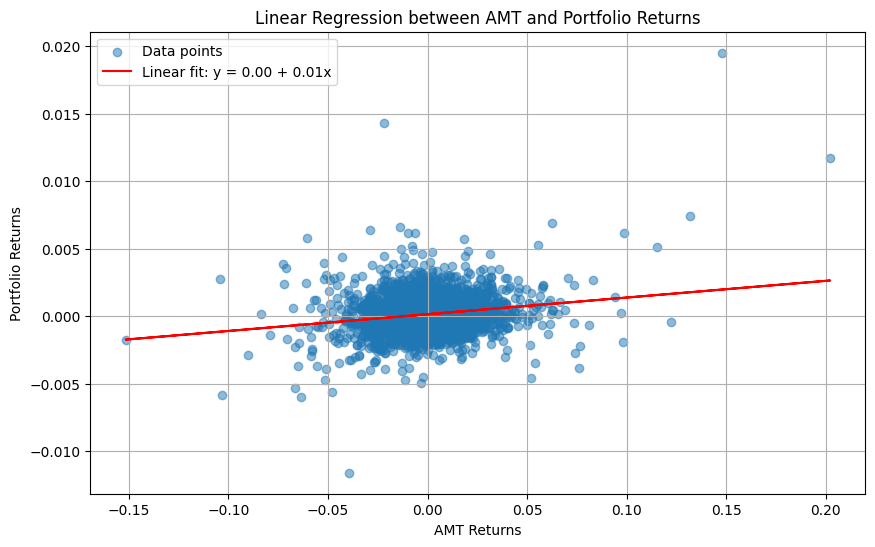

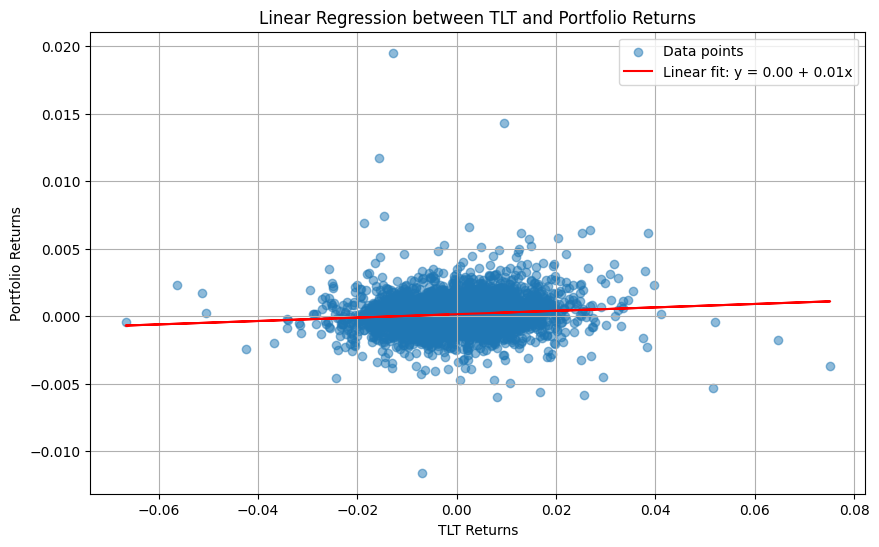

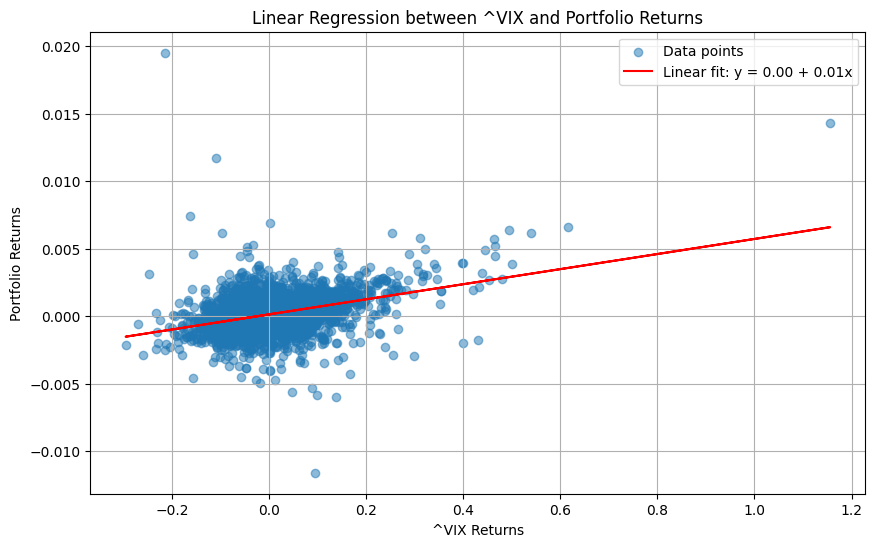

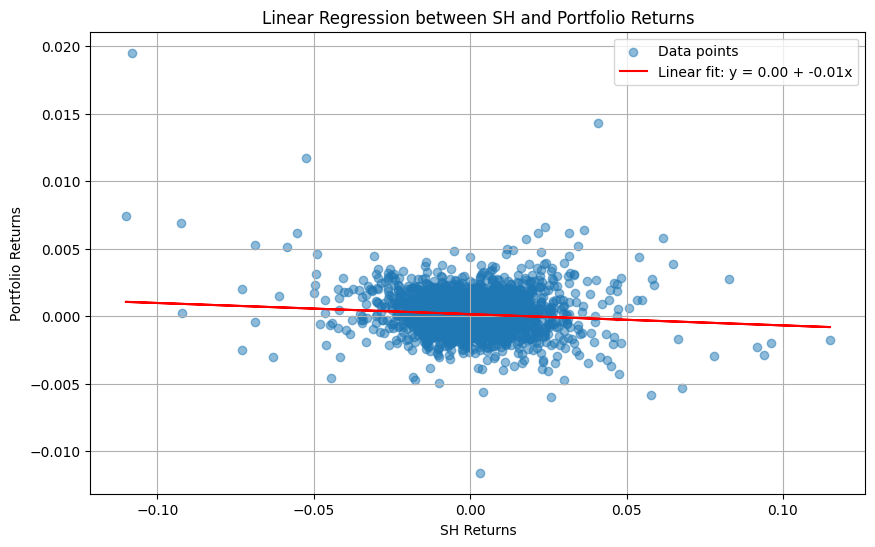

In [8]:
for asset in tickers:
    asset_returns = returns[asset]
    # Fit linear regression
    X = asset_returns.values.reshape(-1, 1)
    y = optimized_portfolio_returns.values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    beta = reg.coef_[0][0]
    alpha = reg.intercept_[0]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(asset_returns, optimized_portfolio_returns, alpha=0.5, label='Data points')
    plt.plot(asset_returns, reg.predict(X), color='red', label=f'Linear fit: y = {alpha:.2f} + {beta:.2f}x')
    plt.title(f"Linear Regression between {asset} and Portfolio Returns")
    plt.xlabel(f"{asset} Returns")
    plt.ylabel('Portfolio Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

Portfolio is not highly correlated with any particular asset.

# Conclusion

This notebook presented a comprehensive approach to constructing and optimizing a portfolio with predefined risk and return objectives. Key findings include:
* Portfolio creation that optimizes the Sharpe ratio while managing risk through specific constraints.
* The inclusion of inverse ETFs and other hedging instruments helps in minimizing potential drawdowns effectively even in stressed market sceanrios.

## Future Work

* Implement Monte Carlo simulations for enhanced scenario generation and better risk management.
* Investigate 2008 financial crisis further to improve sharpe without compromising risk metrics.
* If derivatives data available, include straddles/strangles for equity/commodity vol protection, Credit Default swaps for credit risk.
* Implement trading strategies such as momentum, eq long-short, etc.
  